In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import torch_harmonics as th
import torch
import numpy as np
import matplotlib as mpl
from datetime import datetime, timedelta
import cartopy.crs as ccrs

In [2]:
import xarray as xr
import glob

DATES = [
    "2020-01-06T00:00:00",
    "2020-01-13T00:00:00",
    "2020-01-20T00:00:00",
    "2020-01-27T00:00:00",
    "2020-02-03T00:00:00",
    "2020-02-10T00:00:00",
    "2020-02-17T00:00:00",
    "2020-02-24T00:00:00",
    "2020-03-02T00:00:00",
    "2020-03-09T00:00:00",
    "2020-03-16T00:00:00",
    "2020-03-23T00:00:00",
    "2020-03-30T00:00:00",
    "2020-04-06T00:00:00",
    "2020-04-13T00:00:00",
    "2020-04-20T00:00:00",
    "2020-04-27T00:00:00",
    "2020-05-04T00:00:00",
    "2020-05-11T00:00:00",
    "2020-05-18T00:00:00",
    "2020-05-25T00:00:00",
    "2020-06-01T00:00:00",
    "2020-06-08T00:00:00",
    "2020-06-15T00:00:00",
    "2020-06-22T00:00:00",
    "2020-06-29T00:00:00",
    "2020-07-06T00:00:00",
    "2020-07-13T00:00:00",
    "2020-07-20T00:00:00",
    "2020-07-27T00:00:00",
    "2020-08-03T00:00:00",
    "2020-08-10T00:00:00",
    "2020-08-17T00:00:00",
    "2020-08-24T00:00:00",
    "2020-08-31T00:00:00",
    "2020-09-07T00:00:00",
    "2020-09-14T00:00:00",
    "2020-09-21T00:00:00",
    "2020-09-28T00:00:00",
    "2020-10-05T00:00:00",
    "2020-10-12T00:00:00",
    "2020-10-19T00:00:00",
    "2020-10-26T00:00:00",
    "2020-11-02T00:00:00",
    "2020-11-09T00:00:00",
    "2020-11-16T00:00:00",
    "2020-11-23T00:00:00",
    "2020-11-30T00:00:00",
    "2020-12-14T00:00:00",]

def load_files(metric, base_path):
    # Define the base path
    
    
    subdirectories = [f"{base_path}/{date_str}" for date_str in DATES]

    # Initialize an empty list to store xarray datasets
    datasets = []

    # Iterate over each subdirectory
    for subdirectory in sorted(subdirectories):
        # Construct the full path to ensemble_mse.zarr within each subdirectory
        file_path = subdirectory + f"/{metric}.zarr"
        
        # Open the Zarr file as an xarray dataset
        dataset = xr.open_zarr(file_path, decode_times=False)
        # Append the dataset to the list of datasets
        datasets.append(dataset)

    # Concatenate all datasets along the time dimension
    return xr.concat(datasets, dim='initial_time')

base_path = "/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0_part2020/"
sfno_e620_sc2 = load_files("ensemble", base_path)

base_path = "/pscratch/sd/a/amahesh/hens/time_collection/sc6_e220/"
sfno_e220_sc6 = load_files("ensemble", base_path)

base_path = "/pscratch/sd/a/amahesh/hens/time_collection/sc4_e384/"
sfno_e384_sc4 = load_files("ensemble", base_path)

In [4]:
def calculate_spectrum(KE_500):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # calculate the spherical harmonic transform of KE_500
    ntime = len(KE_500.time)
    nlat = len(KE_500.lat)
    nlon = len(KE_500.lon)
    print(ntime)
    # initialize the scalar spherical harmonic transform
    sht = th.RealSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # initialize the vector spherical harmonic transform
    #vsht = th.RealVectorSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # initialize the spherical harmonic vector inverse transform
    #ivsht = th.InverseRealVectorSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # calculate the SHT coefficients
    coeffs = sht(torch.from_numpy(KE_500.values).to(device))

    # normalize by Earth's surface area [m^2]
    r_earth = 6.371e6
    a_earth = 4*np.pi*r_earth**2
    
    # calculate the power spectrum
    # the SHT coefficient dimensions are (time, l, m)
    l_array = torch.arange(0, nlat, device = device)[None, :] * torch.ones(ntime, nlat, device = device)
    P_KE_500 = torch.real((2/(2*l_array + 1)) * torch.sum(coeffs * torch.conj(coeffs), dim = -1))

    l = np.arange(nlat)
    P_KE_500 = P_KE_500.numpy(force = True)

    # convert spherical harmonic degree to wavelength [km]
    lam = 2*np.pi*r_earth/(l + 1) / 1e3
    
    return lam, P_KE_500, ntime


In [5]:
spectra = []
for dataset in [sfno_e620_sc2, sfno_e384_sc4, sfno_e220_sc6]:
    lam_sfno, curr, ntime = calculate_spectrum(dataset['t850'].isel(ensemble=0,time=-1,drop=True).rename({
        'initial_time' : 'time'}))
    spectra.append(curr)

49
49
49


In [6]:
lam_sfno, era5_spectrum, ntime = calculate_spectrum(sfno_e620_sc2['t850'].isel(ensemble=0,time=0,drop=True).rename({
        'initial_time' : 'time'}))

49


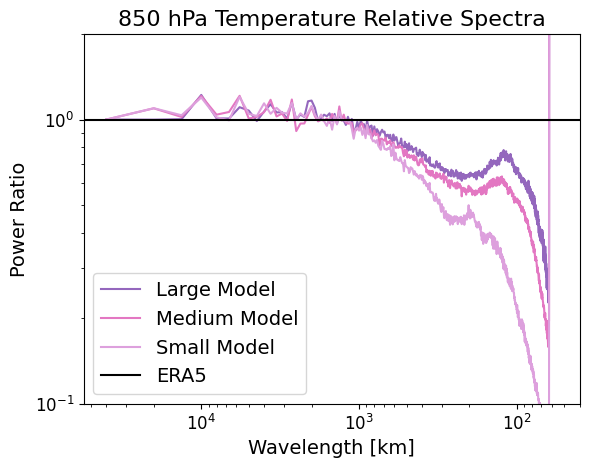

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})

titles = ['Large Model', 'Medium Model', 'Small Model']
linestyles = ['solid', 'dashed', 'dotted']

colors = ['C4', 'C6', 'plum']

for i, spectrum in enumerate(spectra):
    plt.plot(lam_sfno, (spectrum / spectrum[:, 0:1]).mean(0) / (era5_spectrum / era5_spectrum[:, 0:1]).mean(0),
             label=titles[i], color=colors[i])
    
plt.axhline(1, color='black', label='ERA5')
# plt.axhline(1, color='black', label="ERA5")
plt.xlabel("Wavelength [km]")
plt.ylabel("Power Ratio")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlim(plt.xlim()[::-1])
plt.title("850 hPa Temperature Relative Spectra")
plt.ylim((10**-1, 2))
# plt.xlim((5000, 50))
plt.show()


In [8]:
from earth2mip import forecast_metrics_io
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
def convert_lead(ds):
    ds['lead_time'] = ds['lead_time'] / np.timedelta64(1, 'h')
    
def get_spread_skill(ds, var):
    if 'initial_time' in ds.coords:
        skill = ds.mean('initial_time').sel(channel=var, metric='MSE_mean') ** 0.5
        spread = ds.mean('initial_time').sel(channel=var, metric='variance') ** 0.5
    else:
        skill = ds.sel(channel=var, variable='rmse_mean')
        spread = ds.sel(channel=var, variable='variance') ** 0.5
    return spread, skill
PATH = "/pscratch/sd/a/amahesh/hens/lagged_ensembles/prod/sfno_linear_73chq_sc{}_layers8_edim220_wstgl2/"
sc6_e220 = forecast_metrics_io.read_metrics(PATH.format(6)).to_xarray()

sc2_e620 = forecast_metrics_io.read_metrics("/pscratch/sd/a/amahesh/hens/lagged_ensembles/prod/sfno_linear_74chq_sc2_layers8_edim620_wstgl2-epoch70_seed17/").to_xarray()
sc4_e384 = forecast_metrics_io.read_metrics(PATH.format(4).replace('220','384')).to_xarray()

In [9]:
convert_lead(sc6_e220)
convert_lead(sc2_e620)
convert_lead(sc4_e384)

In [10]:
scale_factor = xr.DataArray(['6 embed220', '4 embed384', '2 embed620'], dims='scale_factor')
combined = xr.concat([sc6_e220, sc4_e384, sc2_e620], dim=scale_factor)

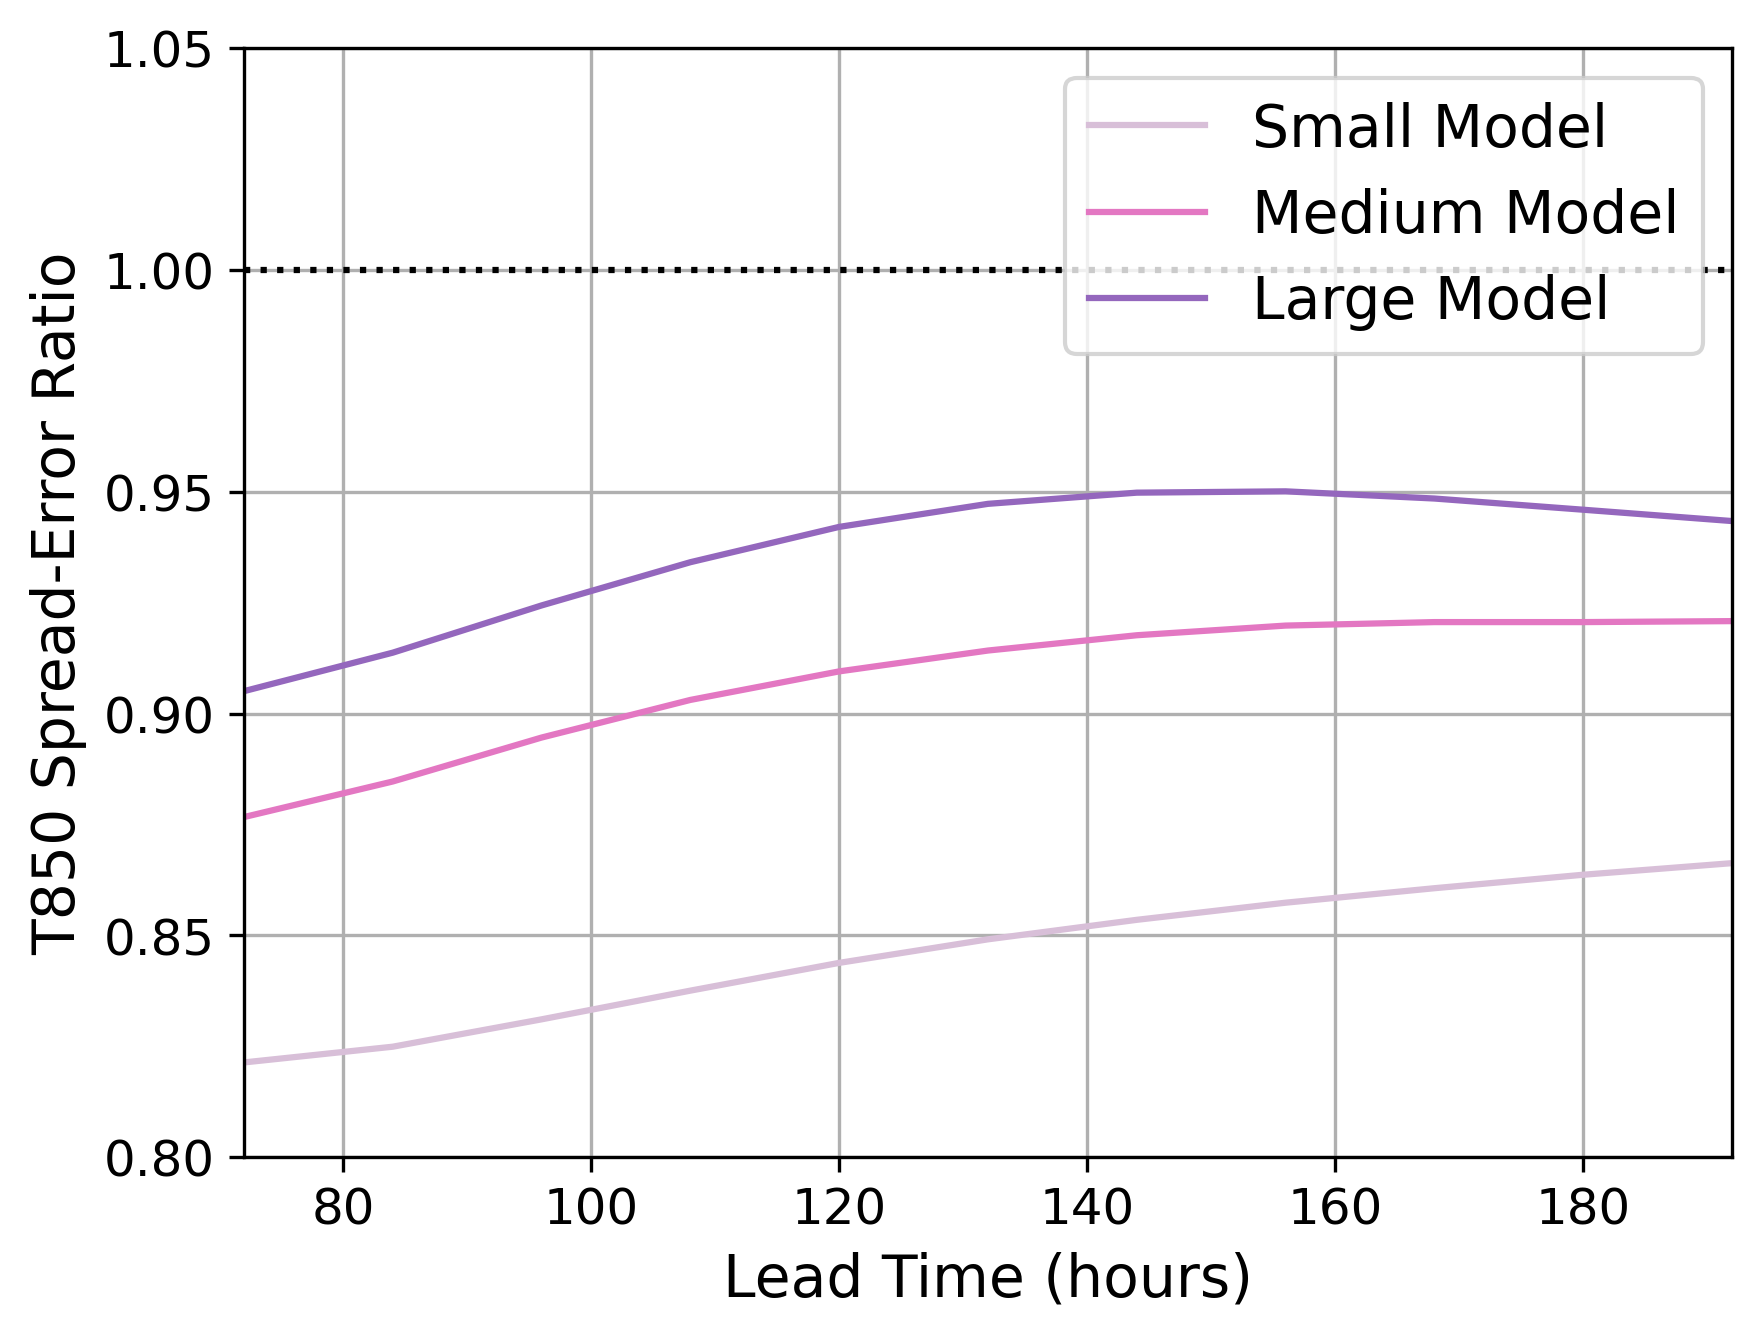

In [12]:
fig, (ax2) = plt.subplots(nrows=1,ncols=1,
                                 dpi=300)



ax2.axhline(1.0, linestyle='dotted', color='black')
make_ssr_figure(ax2, combined, 't850')
ax2.set_ylim((0.8, 1.05))
ax2.legend()

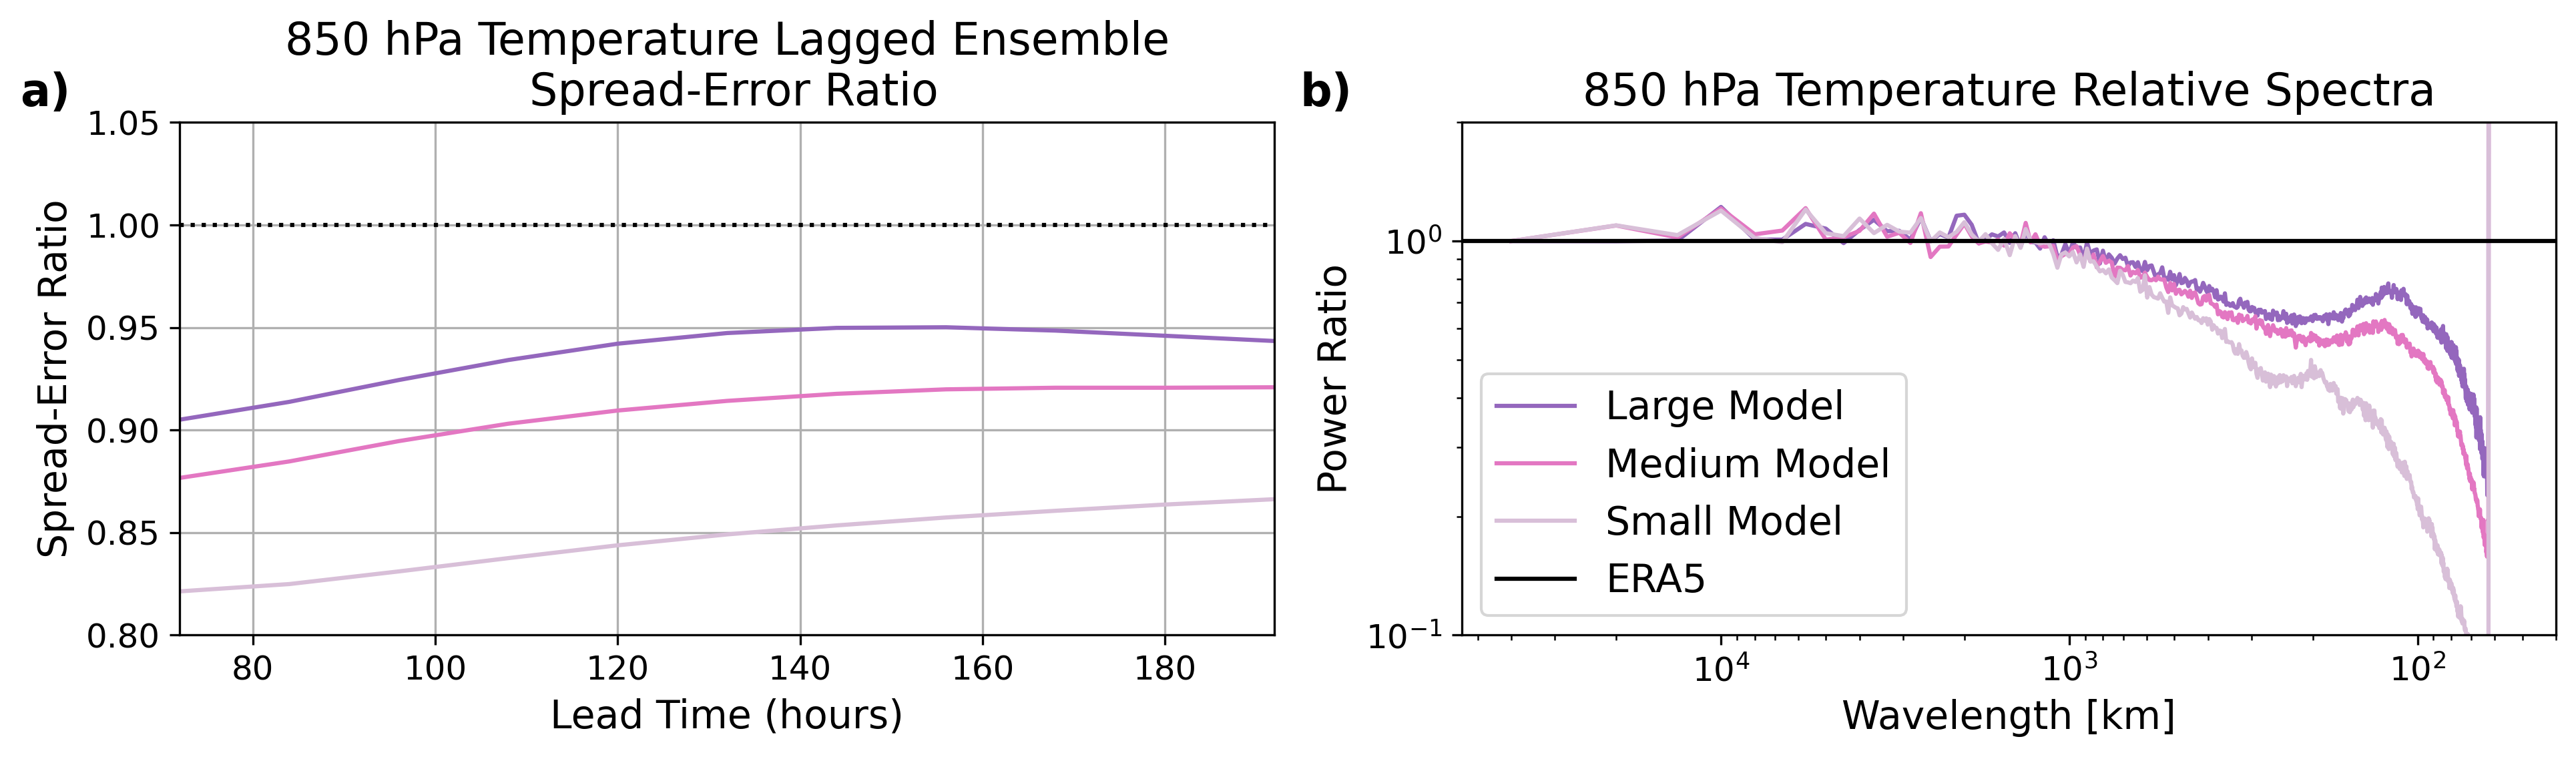

In [19]:
fig, (ax2, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(13,4),
                                 dpi=300)

plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14
})

titles = ['Large Model', 'Medium Model', 'Small Model']
linestyles = ['solid', 'dashed', 'dotted']

colors = ['C4', 'C6', 'thistle']

for i, spectrum in enumerate(spectra):
    ax1.plot(lam_sfno, (spectrum / spectrum[:, 0:1]).mean(0) / (era5_spectrum / era5_spectrum[:, 0:1]).mean(0),
             label=titles[i], color=colors[i])
    
ax1.axhline(1, color='black', label='ERA5')
# plt.axhline(1, color='black', label="ERA5")
ax1.set_xlabel("Wavelength [km]")
ax1.set_ylabel("Power Ratio")
ax1.legend()
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.set_title("850 hPa Temperature Relative Spectra")
ax1.set_ylim((10**-1, 2))


ax2.axhline(1.0, linestyle='dotted', color='black')
make_ssr_figure(ax2, combined, 't850')
ax2.set_title("850 hPa Temperature Lagged Ensemble\n Spread-Error Ratio")

ax2.set_ylim((0.8, 1.05))

# Add labels "a" and "b"
ax1.text(-0.1, 1.1, 'b)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.1, 'a)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig("hyperparameter_tuning.pdf")
plt.show()